# RUBBERY MODULUS

In [1]:
# import required packages

import traceback
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn. preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras import layers
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem

### Data processing

In [2]:
# read data
filePath = r"C:\Users\Ama\OneDrive - Southern University System\02-MachineLearning\Dataset_for_practise\SMP-Er.csv"
df = pd.read_csv(filePath)

In [3]:
#
smiles = df['Smiles']
smiles = [list(smile.strip('{} ').split(',')) for smile in smiles]

molar_ratio = df['Molar ratio']
m_r = []
for entry in molar_ratio:
    ratio_list = [float(x) for x in entry.split(':')]
    m_r.append(ratio_list)

In [4]:
''''
functions for fingerprinting and multiplication of 
fingerprinted monomers by their respective molar ratios
'''
#function for fingerprinting
def fingerprint_monomer(monomer):
    mol = Chem.MolFromSmiles(monomer)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 7, nBits=1028)
    return fp

#function for storing fingerprints monomers as a representation of the polymers
def fingerprint_polymer(polymer):
    polymer_fp = []
    for monomer in polymer:
        monomer_fp = fingerprint_monomer(monomer)
        polymer_fp.append(monomer_fp)
    return polymer_fp

# function for multiplication by their respective molar ratios
def multiply_fingerprint(fp, m_r_value):
    return np.multiply(fp, m_r_value)

fingerprinted_polymer_data = []
for polymer, polymer_m_r in zip(smiles, m_r):
    fingerprinted_polymer = fingerprint_polymer(polymer)
    multiplied_polymer = [multiply_fingerprint(fp, m_r_value) for fp, m_r_value in zip(fingerprinted_polymer, polymer_m_r)]
    fingerprinted_polymer_data.append(multiplied_polymer)
    

#flatten the array created and storing them in a list
flattened_arr = [np.concatenate(arr) for arr in fingerprinted_polymer_data]

#find the maximum length of the flattened arrays
max_length = max(len(arr) for arr in flattened_arr)

# pad the arrays with zeros to make them the same length
padded_arrays = [np.pad(arr, (0, max_length - len(arr)), mode = 'constant') for arr in flattened_arr]

new_array = np.stack(padded_arrays)

In [5]:
X = new_array
y = df['Rubbery modulus'] #specify y

In [6]:
#Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Initialize the scaler
scaler = RobustScaler()

# Fit the scaler on the training data and transform it
X_train_normalized = scaler.fit_transform(X_train)

# Apply the same transformation to the test data
X_test_normalized = scaler.transform(X_test)

x_plot = np.linspace(0, 12)
y_plot = x_plot

### ANN Model

Epoch 1/1000
7/7 [==============================] - 4s 73ms/step - loss: 23.5017 - mape: 99.3918 - val_loss: 22.6976 - val_mape: 98.5103
Epoch 2/1000
7/7 [==============================] - 0s 24ms/step - loss: 23.3312 - mape: 96.8965 - val_loss: 22.5061 - val_mape: 96.2993
Epoch 3/1000
7/7 [==============================] - 0s 25ms/step - loss: 23.0459 - mape: 93.1140 - val_loss: 21.4565 - val_mape: 84.7401
Epoch 4/1000
7/7 [==============================] - 0s 42ms/step - loss: 19.9784 - mape: 72.8907 - val_loss: 16.0162 - val_mape: 77.7463
Epoch 5/1000
7/7 [==============================] - 0s 42ms/step - loss: 15.6863 - mape: 124.0717 - val_loss: 13.0304 - val_mape: 73.9623
Epoch 6/1000
7/7 [==============================] - 0s 41ms/step - loss: 12.6275 - mape: 80.9710 - val_loss: 8.8499 - val_mape: 52.1806
Epoch 7/1000
7/7 [==============================] - 0s 37ms/step - loss: 11.4206 - mape: 66.5611 - val_loss: 8.7641 - val_mape: 36.4380
Epoch 8/1000
7/7 [========================

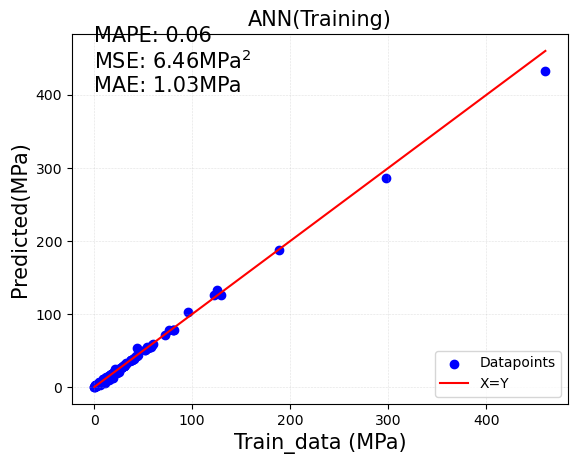

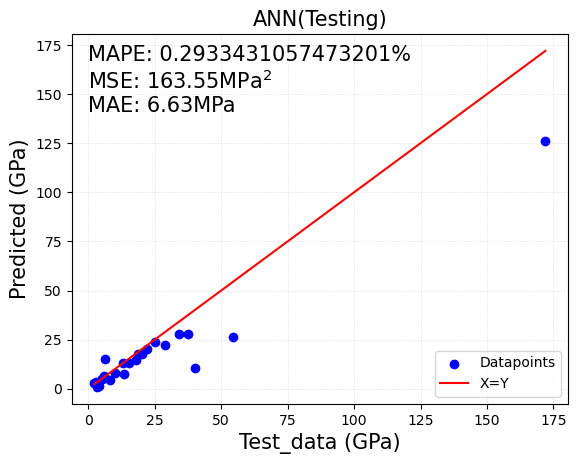

In [11]:
learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# Define the ANN model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1)
])


# Compile the model
model.compile(loss='mae',optimizer=optimizer, metrics=['mape'])

# Train the model
history = model.fit(X_train, y_train, epochs=1000,  batch_size= 32, validation_data=(X_test, y_test))
# Predict on the test set
predicted_values = model.predict(X_test)


y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate the error
MAPE_train = mean_absolute_percentage_error(y_train, y_train_pred)
MAPE_test = mean_absolute_percentage_error(y_test, y_test_pred)

MSE_train = mean_squared_error(y_train, y_train_pred)
MSE_test= mean_squared_error(y_test, y_test_pred)

MAE_train = mean_absolute_error(y_train, y_train_pred)
MAE_test= mean_absolute_error(y_test, y_test_pred)


# Plot actual and predicted values for training set
plt.scatter(y_train, y_train_pred, color='b', label='Datapoints')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='r', label='X=Y')
plt.xlabel('Train_data (MPa)', fontsize=15)
plt.ylabel('Predicted(MPa)', fontsize = 15)
plt.text(0,
        495,
        f"MAPE: {MAPE_train:.2f}\nMSE: {MSE_train:.2f}MPa$^2$\nMAE: {MAE_train:.2f}MPa",
        ha="left",
        va="top",
        fontsize=15,)
plt.grid(True, which='both', linestyle='dotted', linewidth=0.4, alpha=0.7)
plt.legend(loc= 'lower right')
plt.title('ANN(Training)', fontsize= 15)
#plt.legend()
plt.show()

plt.scatter(y_test, y_test_pred, color='b', label='Datapoints')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', label='X=Y')
plt.xlabel('Test_data (GPa)', fontsize = 15)
plt.ylabel('Predicted (GPa)', fontsize=15)
plt.text(0,
        175,
        f"MAPE: {MAPE_test}%\nMSE: {MSE_test:.2f}MPa$^2$\nMAE: {MAE_test:.2f}MPa",
        ha="left",
        va="top",
        fontsize=15,)
plt.grid(True, which='both', linestyle='dotted', linewidth=0.4, alpha=0.7)
plt.legend(loc= 'lower right')
plt.title('ANN(Testing)', fontsize=15)
#plt.legend()
plt.show()

### REDUCED MODEL COMPLEXITY

Epoch 1/500
7/7 [==============================] - 3s 69ms/step - loss: 19.4486 - mape: 84.7271 - val_loss: 15.4290 - val_mape: 93.2837
Epoch 2/500
7/7 [==============================] - 0s 16ms/step - loss: 15.2887 - mape: 118.7005 - val_loss: 13.3559 - val_mape: 60.0838
Epoch 3/500
7/7 [==============================] - 0s 20ms/step - loss: 12.8057 - mape: 64.7082 - val_loss: 10.6396 - val_mape: 41.8514
Epoch 4/500
7/7 [==============================] - 0s 20ms/step - loss: 11.4954 - mape: 69.8381 - val_loss: 9.4704 - val_mape: 41.8697
Epoch 5/500
7/7 [==============================] - 0s 37ms/step - loss: 10.0635 - mape: 50.9551 - val_loss: 9.0665 - val_mape: 40.9947
Epoch 6/500
7/7 [==============================] - 0s 34ms/step - loss: 9.5655 - mape: 53.6291 - val_loss: 8.1527 - val_mape: 38.3553
Epoch 7/500
7/7 [==============================] - 0s 23ms/step - loss: 8.9303 - mape: 45.6158 - val_loss: 7.7972 - val_mape: 34.9116
Epoch 8/500
7/7 [==============================] - 0s

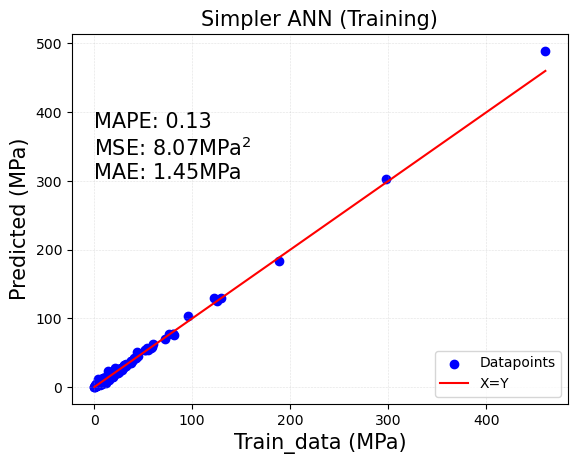

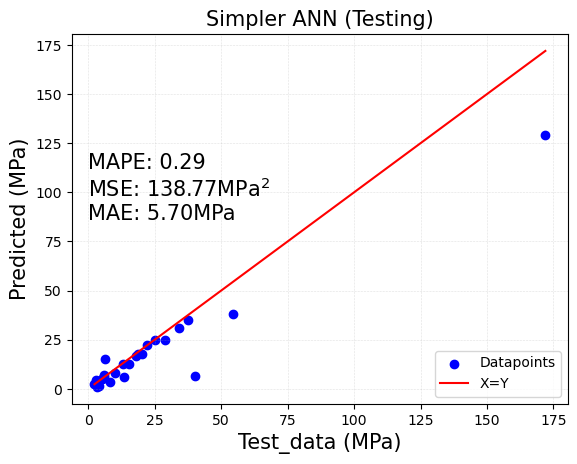

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Assuming you have your data loaded as X_train, y_train, X_test, y_test

# Reduce Model Complexity
learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Define the simpler ANN model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(loss='mae', optimizer=optimizer, metrics=['mape'])

# Train the model
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test))

# ... (Prediction and evaluation code)

# Predict on the test set
predicted_values = model.predict(X_test)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate the error
MAPE_train = mean_absolute_percentage_error(y_train, y_train_pred)
MAPE_test = mean_absolute_percentage_error(y_test, y_test_pred)

MSE_train = mean_squared_error(y_train, y_train_pred)
MSE_test= mean_squared_error(y_test, y_test_pred)

MAE_train = mean_absolute_error(y_train, y_train_pred)
MAE_test= mean_absolute_error(y_test, y_test_pred)

# Plot actual and predicted values for training set
plt.scatter(y_train, y_train_pred, color='b', label='Datapoints')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='r', label='X=Y')
plt.xlabel('Train_data (MPa)', fontsize=15)
plt.ylabel('Predicted (MPa)', fontsize=15)
plt.grid(True, which='both', linestyle='dotted', linewidth=0.4, alpha=0.7)
plt.text(0,
        500,
        f"MAPE: {MAPE_train:.2f}\nMSE: {MSE_train:.2f}MPa$^2$\nMAE: {MAE_train:.2f}MPa",
        ha="left",
        va="top",
        fontsize=15,)
plt.legend(loc='lower right')
plt.title('Simpler ANN (Training)', fontsize=15)
plt.show()

# Plot actual and predicted values for testing set
plt.scatter(y_test, y_test_pred, color='b', label='Datapoints')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', label='X=Y')
plt.xlabel('Test_data (MPa)', fontsize=15)
plt.ylabel('Predicted (MPa)', fontsize=15)
plt.text(0,
        120,
        f"MAPE: {MAPE_test:.2f}\nMSE: {MSE_test:.2f}MPa$^2$\nMAE: {MAE_test:.2f}MPa",
        ha="left",
        va="top",
        fontsize=15,)
plt.grid(True, which='both', linestyle='dotted', linewidth=0.4, alpha=0.7)
plt.legend(loc='lower right')
plt.title('Simpler ANN (Testing)', fontsize=15)
plt.show()


### LEARNING RATE SCHEDULE

Epoch 1/500
7/7 [==============================] - 2s 66ms/step - loss: 92.7064 - mae: 22.9927 - val_loss: 75.5412 - val_mae: 20.5763 - lr: 0.0100
Epoch 2/500
7/7 [==============================] - 0s 17ms/step - loss: 69.5137 - mae: 18.9188 - val_loss: 63.6522 - val_mae: 17.1934 - lr: 0.0100
Epoch 3/500
7/7 [==============================] - 0s 21ms/step - loss: 61.5477 - mae: 16.8942 - val_loss: 59.5761 - val_mae: 17.6329 - lr: 0.0100
Epoch 4/500
7/7 [==============================] - 0s 20ms/step - loss: 53.9714 - mae: 16.9229 - val_loss: 56.8221 - val_mae: 16.6587 - lr: 0.0100
Epoch 5/500
7/7 [==============================] - 0s 21ms/step - loss: 50.2937 - mae: 15.2826 - val_loss: 55.3682 - val_mae: 14.8645 - lr: 0.0100
Epoch 6/500
7/7 [==============================] - 0s 20ms/step - loss: 45.6992 - mae: 14.1760 - val_loss: 51.7378 - val_mae: 14.5875 - lr: 0.0100
Epoch 7/500
7/7 [==============================] - 0s 18ms/step - loss: 42.3334 - mae: 13.0087 - val_loss: 49.4509 - v

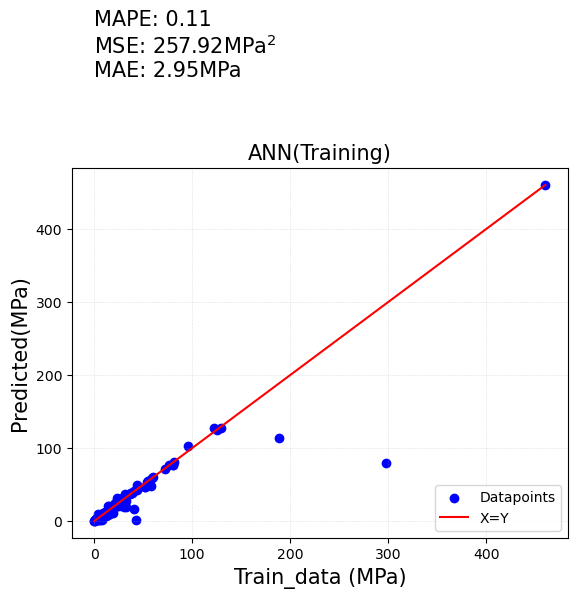

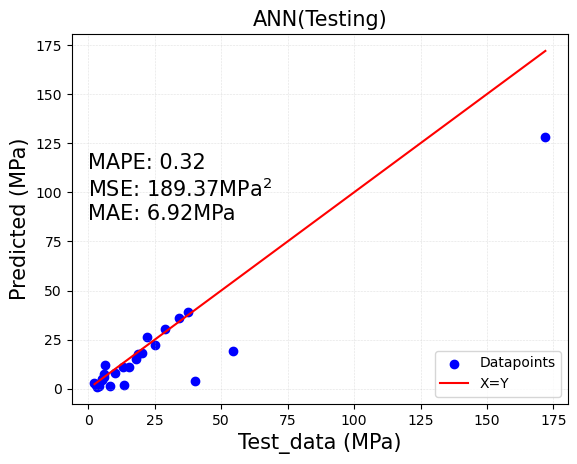

In [9]:

# Define learning rate schedule function
def lr_schedule(epoch, lr):
    if epoch < 100:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Reduce Model Complexity
learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Define the simpler ANN model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(loss='mape', optimizer=optimizer, metrics=['mae'])

# Define LearningRateScheduler callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=50),
        lr_scheduler
    ]
)

# Predict on the test set
predicted_values = model.predict(X_test)


y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate the error
MAPE_train = mean_absolute_percentage_error(y_train, y_train_pred)
MAPE_test = mean_absolute_percentage_error(y_test, y_test_pred)

MSE_train = mean_squared_error(y_train, y_train_pred)
MSE_test= mean_squared_error(y_test, y_test_pred)

MAE_train = mean_absolute_error(y_train, y_train_pred)
MAE_test= mean_absolute_error(y_test, y_test_pred)


# Plot actual and predicted values for training set
plt.scatter(y_train, y_train_pred, color='b', label='Datapoints')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='r', label='X=Y')
plt.xlabel('Train_data (MPa)', fontsize=15)
plt.ylabel('Predicted(MPa)', fontsize = 15)
plt.text(0,
        700,
        f"MAPE: {MAPE_train:.2f}\nMSE: {MSE_train:.2f}MPa$^2$\nMAE: {MAE_train:.2f}MPa",
        ha="left",
        va="top",
        fontsize=15,)
plt.grid(True, which='both', linestyle='dotted', linewidth=0.4, alpha=0.7)
plt.legend(loc= 'lower right')
plt.title('ANN(Training)', fontsize= 15)
#plt.legend()
plt.show()

plt.scatter(y_test, y_test_pred, color='b', label='Datapoints')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', label='X=Y')
plt.xlabel('Test_data (MPa)', fontsize = 15)
plt.ylabel('Predicted (MPa)', fontsize=15)
plt.text(0,
        120,
        f"MAPE: {MAPE_test:.2f}\nMSE: {MSE_test:.2f}MPa$^2$\nMAE: {MAE_test:.2f}MPa",
        ha="left",
        va="top",
        fontsize=15,)
plt.grid(True, which='both', linestyle='dotted', linewidth=0.4, alpha=0.7)
plt.legend(loc= 'lower right')
plt.title('ANN(Testing)', fontsize=15)
#plt.legend()
plt.show()